In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# simulation of data. Two state model for simplicity.
N_seqs = 1000
N_labels = 3
N_states = 2

# transition probability
P = np.array([[0.8, 0.2], [0.4, 0.6]])
# emission probabilityu
Pe = np.array([
    [0.8, 0.1, 0.1],
    [0.3, 0.4, 0.3]
])
N_labels = Pe.shape[1]

AA = np.eye(N_states) - P + np.ones(shape=(N_states, N_states))
PA = np.linalg.solve(AA.T, np.ones(shape=(N_states)))

state_seq = [np.random.choice(N_states, p=PA)]
for i in range(1, N_seqs):
    state_seq += [np.random.choice(N_states, p=P[state_seq[-1]])]

label_seq = [np.random.choice(N_labels, p=Pe[state_seq[i]])
             for i in range(N_seqs)]

print(state_seq[:20])
print(label_seq[:20])

[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 2, 0, 0, 1]


In [3]:
with pm.Model() as model:
    Pt = pm.Dirichlet('P_transition', a=np.ones(
        (N_states, N_states)), shape=(N_states, N_states))

    AA = tt.eye(N_states) - Pt + tt.ones(shape=(N_states, N_states))
    PA = pm.Deterministic('P_start_transition', tt.slinalg.solve(
        AA.T, tt.ones(shape=(N_states))))

    states = tt.log(PA[state_seq[0]])
    for i in range(1, len(state_seq)):
        states += tt.log(Pt[state_seq[i-1]][state_seq[i]])
    pm.Potential('logp', states)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [P_transition]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 612.27draws/s] 


In [4]:
trace['P_transition'].mean(axis=0)

array([[0.76329158, 0.23670842],
       [0.41830258, 0.58169742]])

In [5]:
with pm.Model() as model:
    Pt = pm.Dirichlet('P_transition', 
                     a=np.ones((N_states, N_states)), 
                     shape=(N_states, N_states), 
                     testval=np.array([[0.8, 0.2], [0.4, 0.6]]))

    AA = tt.eye(N_states) - Pt + tt.ones(shape=(N_states, N_states))
    PA = pm.Deterministic('P_start_transition', tt.slinalg.solve(
        AA.T, tt.ones(shape=(N_states))))


In [6]:
Pt[state_seq[:-1]][np.arange(N_seqs-1), state_seq[1:]].tag.test_value.shape

(999,)

In [7]:
with model:
    pm.Potential('logp', 
                 tt.log(PA[state_seq[0]]) + 
                 tt.log(Pt[state_seq[:-1]][np.arange(N_seqs-1), state_seq[1:]]).sum())
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [P_transition]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 663.18draws/s]


In [8]:
trace['P_transition'].mean(axis=0)

array([[0.7633734 , 0.2366266 ],
       [0.41943124, 0.58056876]])

## Forward algorithm 
https://github.com/stan-dev/example-models/blob/master/misc/hmm/hmm-semisup.stan

```stan
model {
  for (k in 1:K) 
    theta[k] ~ dirichlet(alpha);
  for (k in 1:K)
    phi[k] ~ dirichlet(beta);
  for (t in 1:T)
    w[t] ~ categorical(phi[z[t]]);
  for (t in 2:T)
    z[t] ~ categorical(theta[z[t-1]]);

  { 
    // forward algorithm computes log p(u|...)
    real acc[K];
    real gamma[T_unsup,K];
    for (k in 1:K)
      gamma[1,k] <- log(phi[k,u[1]]);
    for (t in 2:T_unsup) {
      for (k in 1:K) {
        for (j in 1:K)
          acc[j] <- gamma[t-1,j] + log(theta[j,k]) + log(phi[k,u[t]]);
        gamma[t,k] <- log_sum_exp(acc);
      }
    }
    increment_log_prob(log_sum_exp(gamma[T_unsup]));
  }
```

In [9]:
from scipy.special import logsumexp


def forward(theta, phi, u):
    """
    Forward algorithm: computes the log-likelihood of the observed data, 
    given the model. Performs computations in log-space to avoid underflow
    issues. Computes and returns the full forward matrix, and the final 
    sum-of-all-paths probabilities.

    Parameters
    ----------
    theta: transit probs, K*K
    phi: emission probs, K*V
    u: length T array, observed emission

    Returns
    -------
    score: float, log-probability (score) of observed sequence relative to model, 
    alpha: array-like, full forward matrix
    """
    K, V = phi.shape
    T = u.shape[0]
    alpha = np.zeros(K)
    gamma = np.zeros((T, K))
    gamma[0, :] = np.log(phi[:, u[0]])

    for t in range(1, T):
        alpha = gamma[t-1, :] + np.log(theta).T + np.tile(np.log(phi[:, u[t]]), (K, 1)).T
        gamma[t, :] = logsumexp(alpha, axis=1)
    score = logsumexp(gamma[-1, :])
    return score, gamma

In [10]:
score, gamma_sq = forward(P, Pe, np.array(label_seq))

In [ ]:
import theano

theta = tt.matrix()
theta.tag.test_value = P
phi = tt.matrix()
phi.tag.test_value = Pe
observed = tt.vector()
observed.tag.test_value = np.array(label_seq)

gamma = tt.log(phi[:, label_seq[0]])
gamma = tt.tile(gamma, (1, 1)).T

def onestep(obs, gamma_, theta, phi):
#     i = tt.cast(obs, 'int32')
    i = obs
    alpha = gamma_ + tt.log(theta) + tt.tile(tt.log(phi[:, i]), (phi.shape[0], 1))
    return pm.math.logsumexp(alpha, axis=0).T

In [11]:
# test theano implementation
i = 20
temp = onestep(label_seq[i+1], gamma, P, Pe)
# temp.eval({gamma: np.tile(gamma_sq[1], (1, 1)).T})
np.testing.assert_array_equal(
    temp.eval({gamma: np.tile(gamma_sq[i], (1, 1)).T}).squeeze(),
    gamma_sq[i+1])

In [12]:
def onestep(obs, gamma_, theta, phi):
    i = tt.cast(obs, 'int32')
#     i = obs
    alpha = gamma_ + tt.log(theta) + tt.tile(tt.log(phi[:, i]), (phi.shape[0], 1))
    return pm.math.logsumexp(alpha, axis=0).T

T = len(label_seq)
# Symbolic description of the result
result, updates = theano.scan(fn=onestep,
                              outputs_info=gamma,
                              sequences=observed,
                              non_sequences=[theta, phi],
                              n_steps=T-1)

final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[observed, gamma, theta, phi], outputs=tt.squeeze(result), updates=updates)

In [13]:
out = power(np.array(label_seq)[1:], np.tile(gamma_sq[0], (1, 1)).T, P, Pe)

In [14]:
out

array([[-4.97580397e-01, -2.28278247e+00],
       [-8.63318847e-01, -2.90333542e+00],
       [-3.32606023e+00, -3.05968643e+00],
       ...,
       [-9.53637766e+02, -9.53310348e+02],
       [-9.53557143e+02, -9.54809825e+02],
       [-9.55949330e+02, -9.55463795e+02]])

In [15]:
gamma_sq[1:]

array([[-4.97580397e-01, -2.28278247e+00],
       [-8.63318847e-01, -2.90333542e+00],
       [-3.32606023e+00, -3.05968643e+00],
       ...,
       [-9.53637766e+02, -9.53310348e+02],
       [-9.53557143e+02, -9.54809825e+02],
       [-9.55949330e+02, -9.55463795e+02]])

## unsupervised model

In [32]:
observed_label = theano.shared(np.array(label_seq))


def onestep(obs, gamma_, theta, phi):
    i = tt.cast(obs, 'int32')
    alpha = gamma_ + tt.log(theta) + \
        tt.tile(tt.log(phi[:, i]), (phi.shape[0], 1))
    return pm.math.logsumexp(alpha, axis=0).T


T = len(label_seq)

final_result = result[-1]
with pm.Model() as model:
    Pt = pm.Dirichlet('P_transition',
                      a=np.ones((N_states, N_states)),
                      shape=(N_states, N_states),
                      testval=P)

    Pem = pm.Dirichlet('P_emission',
                       a=np.ones((N_states, N_labels)),
                       shape=(N_states, N_labels),
                       testval=Pe)
    
    gamma = tt.log(Pem[:, label_seq[0]])
    gamma = tt.tile(gamma, (1, 1)).T

    result, updates = theano.scan(fn=onestep,
                                  outputs_info=gamma,
                                  sequences=observed_label,
                                  non_sequences=[Pt, Pem],
                                  n_steps=T-1)
    
    obs_logp = pm.Potential('obs_logp', pm.math.logsumexp(result[-1]))
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [P_emission, P_transition]
Sampling 2 chains: 100%|██████████| 4000/4000 [39:23<00:00,  1.07s/draws] 
The number of effective samples is smaller than 25% for some parameters.


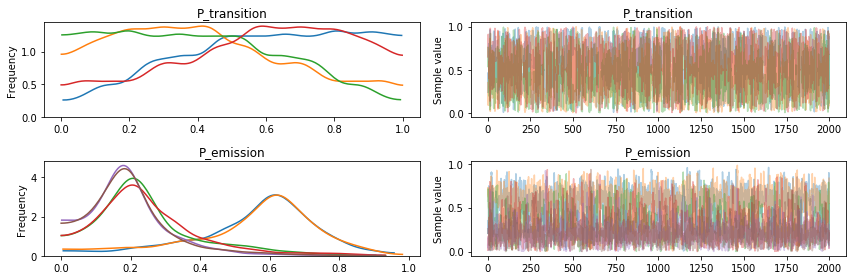

In [34]:
pm.traceplot(trace, combined=True);

In [35]:
trace['P_transition'].mean(axis=0)

array([[0.58889546, 0.41110454],
       [0.42574251, 0.57425749]])

In [36]:
trace['P_emission'].mean(axis=0)

array([[0.5562818 , 0.24878285, 0.19493535],
       [0.55090527, 0.25102301, 0.19807172]])

## semi-supervised model

In [47]:
# split = len(label_seq) // 2
split = 100
state_seq_s = state_seq[:split]
N_seqs = len(state_seq_s)
label_seq_s = label_seq[:split]

observed_label = theano.shared(np.array(label_seq[split:]))


def onestep(obs, gamma_, theta, phi):
    i = tt.cast(obs, 'int32')
    alpha = gamma_ + tt.log(theta) + \
        tt.tile(tt.log(phi[:, i]), (phi.shape[0], 1))
    return pm.math.logsumexp(alpha, axis=0).T


T_unsup = len(label_seq) - split

final_result = result[-1]
with pm.Model() as model:
    Pt = pm.Dirichlet('P_transition',
                      a=np.ones((N_states, N_states)),
                      shape=(N_states, N_states),
                      testval=P)

    AA = tt.eye(N_states) - Pt + tt.ones(shape=(N_states, N_states))
    PA = tt.slinalg.solve(AA.T, tt.ones(shape=(N_states)))
    
    transit_logp = pm.Potential('logp0',
             tt.log(PA[state_seq_s[0]]) + 
             tt.log(Pt[state_seq_s[:-1]][np.arange(N_seqs-1), state_seq_s[1:]]).sum())

    Pem = pm.Dirichlet('P_emission',
                       a=np.ones((N_states, N_labels)),
                       shape=(N_states, N_labels),
                       testval=Pe)
    emission_logp = pm.Categorical('logp1', p=Pem[state_seq_s], observed=label_seq_s)
    
    gamma = tt.log(Pem[:, label_seq[0]])
    gamma = tt.tile(gamma, (1, 1)).T

    result, updates = theano.scan(fn=onestep,
                                  outputs_info=gamma,
                                  sequences=observed_label,
                                  non_sequences=[Pt, Pem],
                                  n_steps=T_unsup-1)
    
    obs_logp = pm.Potential('obs_logp', pm.math.logsumexp(result[-1]))
    
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [P_emission, P_transition]
Sampling 2 chains: 100%|██████████| 4000/4000 [10:18<00:00,  4.22draws/s]


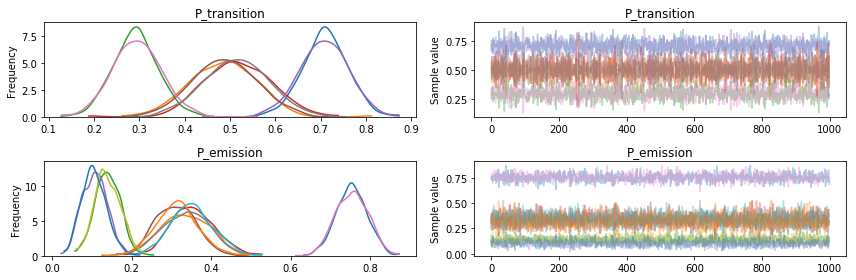

In [48]:
pm.traceplot(trace);

In [49]:
trace['P_transition'].mean(axis=0)

array([[0.70739542, 0.29260458],
       [0.4858351 , 0.5141649 ]])

In [50]:
trace['P_emission'].mean(axis=0)

array([[0.7535102 , 0.14013852, 0.10635128],
       [0.3362632 , 0.35216322, 0.31157359]])